In [2]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Processed_data/claims.csv',index_col=0)
df.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30


In [3]:
df.dropna(subset = ['claim_id','enrollee_id','vetted_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282380 entries, 0 to 319563
Data columns (total 13 columns):
claim_id           282380 non-null float64
enrollee_id        282380 non-null float64
provider_id        282380 non-null float64
provider_status    282380 non-null float64
hmo_id             282380 non-null float64
care_id            282380 non-null float64
qty                282380 non-null float64
amount             282380 non-null float64
approved_qty       282380 non-null float64
approved_amount    282380 non-null float64
hmo_approved       282380 non-null float64
created_at         282380 non-null object
vetted_at          282380 non-null object
dtypes: float64(11), object(2)
memory usage: 30.2+ MB


In [4]:
for col in df.columns[:-1]:
    print(col)
    print(df[col].min(),df[col].max())

claim_id
10.0 64512.0
enrollee_id
1.0 151730.0
provider_id
1.0 426.0
provider_status
1.0 1.0
hmo_id
1.0 5.0
care_id
2.0 88485.0
qty
-30.0 15000.0
amount
-17475.0 2850000.0
approved_qty
-30.0 12000.0
approved_amount
-17475.0 2850000.0
hmo_approved
-1.0 1.0
created_at
2018-03-12 14:53:46 2020-01-10 11:50:15


In [4]:
clean_df = df.loc[(df['qty']>0) & (df['hmo_id'] != 0)]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282055 entries, 0 to 319563
Data columns (total 13 columns):
claim_id           282055 non-null float64
enrollee_id        282055 non-null float64
provider_id        282055 non-null float64
provider_status    282055 non-null float64
hmo_id             282055 non-null float64
care_id            282055 non-null float64
qty                282055 non-null float64
amount             282055 non-null float64
approved_qty       282055 non-null float64
approved_amount    282055 non-null float64
hmo_approved       282055 non-null float64
created_at         282055 non-null object
vetted_at          282055 non-null object
dtypes: float64(11), object(2)
memory usage: 30.1+ MB


In [11]:
for col in clean_df.columns[:-2]:
    print(col)
    print(clean_df[col].min(),clean_df[col].max())

claim_id
10.0 64512.0
enrollee_id
1.0 151730.0
provider_id
1.0 426.0
provider_status
1.0 1.0
hmo_id
1.0 5.0
care_id
2.0 88485.0
qty
1.0 15000.0
amount
0.0 2850000.0
approved_qty
0.0 12000.0
approved_amount
0.0 2850000.0
hmo_approved
-1.0 1.0
created_at
2018-03-12 14:53:46 2020-01-10 11:50:15


In [5]:
clean_df['unite_price'] = clean_df['amount']/clean_df['qty']

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

/Users/shunling/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
clean_df['unite_price'].min(),clean_df['unite_price'].max()

(0.0, 2850000.0)

In [7]:
X = clean_df[['enrollee_id','provider_id','provider_status','hmo_id','care_id','qty','unite_price']]
# the approved cases are True, and would be classified as 0
y = (clean_df['hmo_approved'] == 1) & (clean_df['approved_amount'] == clean_df['amount'])
y = y.map({True:0,False:1})

In [8]:
X.shape,y.shape

((282055, 7), (282055,))

In [9]:
# train_test spilt
Xtrain,Xtest,ytrain,ytest = train_test_split(X.values,y.values,test_size = 0.2,random_state=0)


In [20]:
(ytrain == 0).sum(),(ytrain == 1).sum(),(ytrain == 0).sum()/(ytrain == 1).sum()

(214483, 11161, 19.217184840068093)

In [21]:
(ytest == 0).sum(),(ytest == 1).sum(),(ytest == 0).sum()/(ytest == 1).sum()

(53654, 2757, 19.46100834240116)

In [10]:
def init_scores():
    
    global scores 
    scores = {}
    scores['f1_socre'] = []
    scores['precision'] = []
    scores['recall'] = []
    scores['FPR'] = []
    scores['specificity'] = []
    scores['roc_auc'] = []
    
    return scores


def evaluation(ytest,Xtest,cls):
    global scores
    scores = init_scores()
    ypred = cls.predict(Xtest)
    C = confusion_matrix(ytest,ypred)
    TN = C[0][0]
    FN = C[1][0]
    TP = C[1][1]
    FP = C[0][1]

    print('f1_socre: {:0.3f}'.format(f1_score(ytest,ypred)))
    scores['f1_socre'].append(f1_score(ytest,ypred))
    print('precision: {:0.3f}'.format(TP/(TP+FP)))
    scores['precision'].append(TP/(TP+FP))
    print('recall/sensitivity(true positive rate): {:0.3f}'.format(TP/(TP+FN)))
    scores['recall'].append(TP/(TP+FN))
    print('false positive rate (FPR): {:0.3f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    scores['FPR'].append(1-(TN/(TN+FP)))
    print('spcificity(true negative rate): {:0.3f}'.format(TN/(TN+FP)))
    scores['specificity'].append(TN/(TN+FP))
    print('ROC_AUC_score: {:0.3f}'.format(roc_auc_score(ytest,ypred)))
    scores['roc_auc'].append(roc_auc_score(ytest,ypred))

In [11]:

def cv(Xtrain,ytrain,model):
    global scores
    models = []
    kf = KFold(n_splits=4)
    print(model)
    n = 0
    for train_index, test_index in kf.split(Xtrain):
        print('cross_validate_run: {}'.format(n))
        Xtr, Xte = Xtrain[train_index], Xtrain[test_index]
        ytr, yte = ytrain[train_index], ytrain[test_index]
        cls = model.fit(Xtr, ytr) 
        models.append(cls)
        evaluation(yte,Xte,cls)
        n += 1
    
    print('\n mean scores +/- sd: \n')
    for k in scores:
        print('{} : {:0.3f} +/- {:0.3f}'.format(k, np.array(scores[k]).mean(),  np.array(scores[k]).std()))
        
    scores = init_scores()
    return models

# naive bayes

In [13]:
model1 = ComplementNB()
models_nb1 = cv(Xtrain,ytrain,model1)


ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.104
precision: 0.060
recall/sensitivity(true positive rate): 0.387
false positive rate (FPR): 0.313
spcificity(true negative rate): 0.687
ROC_AUC_score: 0.537
cross_validate_run: 1
f1_socre: 0.109
precision: 0.063
recall/sensitivity(true positive rate): 0.397
false positive rate (FPR): 0.314
spcificity(true negative rate): 0.686
ROC_AUC_score: 0.542
cross_validate_run: 2
f1_socre: 0.104
precision: 0.060
recall/sensitivity(true positive rate): 0.396
false positive rate (FPR): 0.314
spcificity(true negative rate): 0.686
ROC_AUC_score: 0.541
cross_validate_run: 3
f1_socre: 0.107
precision: 0.062
recall/sensitivity(true positive rate): 0.385
false positive rate (FPR): 0.306
spcificity(true negative rate): 0.694
ROC_AUC_score: 0.540

 mean scores +/- sd: 

f1_socre : 0.107 +/- 0.000
precision : 0.062 +/- 0.000
recall : 0.385 +/- 0.000
FPR : 0.306 +/- 0.000
specificity : 0.694 +/- 0.000
ro

In [58]:
evaluation(ytest,Xtest,models_nb1[-1])

f1_socre: 0.108
precision: 0.063
recall/sensitivity(true positive rate): 0.404
false positive rate (FPR): 0.311
spcificity(true negative rate): 0.689
ROC_AUC_score: 0.547


In [41]:
model2 = CategoricalNB()
cv(Xtrain,ytrain,model2)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)
cross_validate_run: 0


IndexError: index 2500000 is out of bounds for axis 1 with size 2200001

# Xgboost

In [14]:
model3 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
              silent=None, subsample=1, verbosity=1)


In [17]:
models_xgb = cv(Xtrain,ytrain,model3)
pickle.dump(models_xgb[1],open("Models/xgb.dat", "wb"))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.245
precision: 0.148
recall/sensitivity(true positive rate): 0.699
false positive rate (FPR): 0.208
spcificity(true negative rate): 0.792
ROC_AUC_score: 0.746
cross_validate_run: 1
f1_socre: 0.254
precision: 0.155
recall/sensitivity(true positive rate): 0.706
false positive rate (FPR): 0.205
spcificity(true negative rate): 0.795
ROC_AUC_score: 0.750
cross_validate_run: 2
f1_socre: 0.247
precision: 0.149
recall/sensitivity(true positive rate): 0.716
false positive rate (FPR): 0.207
spcificit

In [62]:
evaluation(ytest,Xtest,models_xgb[-2])

f1_socre: 0.249
precision: 0.151
recall/sensitivity(true positive rate): 0.715
false positive rate (FPR): 0.207
spcificity(true negative rate): 0.793
ROC_AUC_score: 0.754


In [169]:
#pickle.dump(model5,open("Models/xgb1.dat", "wb"))


(268137, 8) (13918, 8)
ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.459
precision: 0.557
recall/sensitivity(true positive rate): 0.391
false positive rate (FPR): 0.311
spcificity(true negative rate): 0.689
ROC_AUC_score: 0.540
cross_validate_run: 1
f1_socre: 0.463
precision: 0.562
recall/sensitivity(true positive rate): 0.394
false positive rate (FPR): 0.308
spcificity(true negative rate): 0.692
ROC_AUC_score: 0.543
cross_validate_run: 2
f1_socre: 0.454
precision: 0.552
recall/sensitivity(true positive rate): 0.386
false positive rate (FPR): 0.313
spcificity(true negative rate): 0.687
ROC_AUC_score: 0.537
cross_validate_run: 3
f1_socre: 0.458
precision: 0.557
recall/sensitivity(true positive rate): 0.388
false positive rate (FPR): 0.308
spcificity(true negative rate): 0.692
ROC_AUC_score: 0.540

 mean scores +/- sd: 

f1_socre : 0.458 +/- 0.000
precision : 0.557 +/- 0.000
recall : 0.388 +/- 0.000
FPR : 0.308 +/- 0.000
specifici

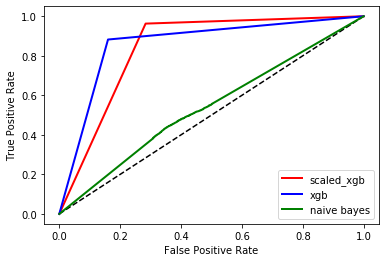

In [15]:
# upsampling of positive data input
Xy = X.copy()
Xy['y'] = y

class0 = Xy.loc[Xy.y == 0]
class1 = Xy.loc[Xy.y == 1]
print(class0.shape,class1.shape)
class1 = class1.sample(n=class0.shape[0],replace=True,random_state=0)
Xy = pd.concat([class0,class1])
yup = Xy['y']
Xup = Xy.drop(columns=['y'])

# re-do train_test split of balanced data
Xuptrain,Xuptest,yuptrain,yuptest = train_test_split(Xup.values,yup.values,test_size = 0.2,random_state=42)
models_nb_up = cv(Xuptrain,yuptrain,model1)

# xgboost with deeper tree
model4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
models_xgb_up = cv(Xuptrain,yuptrain,model4)


# further try to upscale weight of positive class
model5 = model4 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, verbosity=1)
models2_xgb_up = cv(Xuptrain,yuptrain,model5)


# calculate roc curves
xgb_scale_fpr, xgb_scale_tpr, _ = roc_curve(yuptest, models2_xgb_up[2].predict(Xuptest))
xgb_fpr, xgb_tpr, _ = roc_curve(yuptest, models_xgb_up[1].predict(Xuptest))
nb_fpr, nb_tpr, _ = roc_curve(yuptest, models_nb_up[0].predict_proba(Xuptest)[:,1])
# plot the roc curve for the model
plt.plot([0,0.5,1],[0,0.5,1], linestyle='--', color = 'black') # default classification bound
plt.plot(xgb_scale_fpr, xgb_scale_tpr, color = 'r',linewidth=2,label='scaled_xgb')
plt.plot(xgb_fpr, xgb_tpr, color = 'b', linewidth=2,label='xgb')
plt.plot(nb_fpr, nb_tpr, color = 'g',linewidth=2, label='naive bayes')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [16]:
# so far the best model for 
pickle.dump(models_xgb_up[2],open("Models/xgb_up.dat", "wb"))